# Lab 1: Linear Regression and Overfitting

### Machine Learning and Pattern Recognition, September 2015

* The lab exercises should be made in groups of two or three people.
* The deadline is sunday September 20, 23:59.
* Assignment should be sent to Philip Versteeg. (p.j.j.p.versteeg@uva.nl) The subject line of your email should be "\#lab\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.
* Make sure we can run your notebook / scripts!

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact me.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### 1.1. Generate sinusoidal data (5 points)
Write a method `gen_sinusoidal(N)` that generates toy data like in fig 1.2 of the MLPR book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = sin(x_i)$ and the standard deviation $\sigma = 0.2$.


In [1]:
%pylab inline
import numpy as np
import math

def gen_x(N):
    offset = 2 * math.pi / (N - 1)
    for i in range(N):
        yield i * offset

gen_sinusoidal = lambda N: zip(*[(x, np.random.normal(math.sin(x), 0.2, 1)[0]) for x in gen_x(N)])

Populating the interactive namespace from numpy and matplotlib


### 1.2 Polynomial regression (15 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in the MLPR book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates. 

In [2]:
get_phi = lambda X, M: np.array([[x ** i for i in range(M + 1)] for x in X])

def fit_polynomial(X, t, M):
    Phi = get_phi(X, M)
    PhiT = Phi.transpose()
    w = np.linalg.inv(PhiT.dot(Phi)).dot(PhiT).dot(t)
    return w

### 1.3 Plot (5 points)
Sample a dataset with $N=9$, and fit four polynomials with $M \in (0, 1, 3, 9)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the MLPR book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

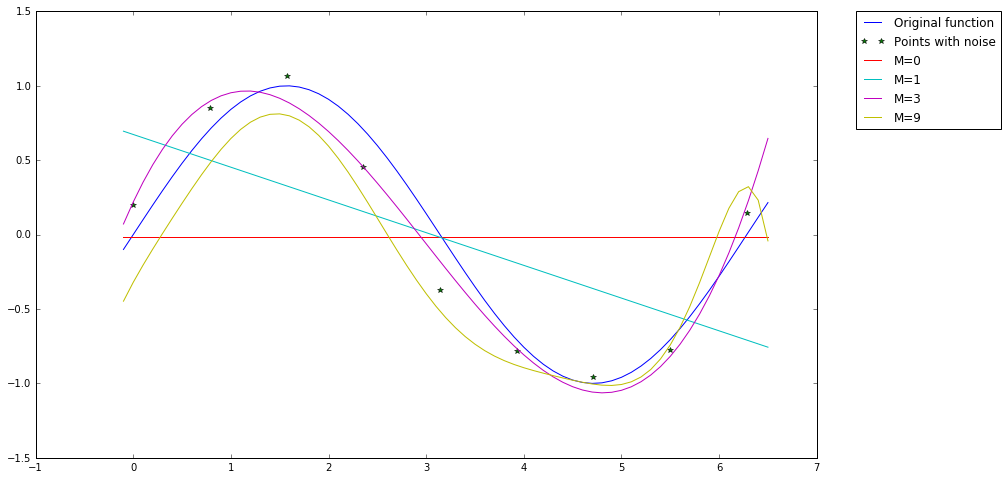

In [3]:
N = 9

import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(14, 8)

X = np.arange(-0.1, 2.1 * math.pi, 0.1)
t = np.sin(X)
plt.plot(X, t, label='Original function')

X_train, t_train = gen_sinusoidal(N)
plt.plot(X_train, t_train, '*', label='Points with noise')
for M in [0, 1, 3, 9]:
    w = fit_polynomial(X_train, t_train, M)
    t_fit = get_phi(X, M).dot(w)
    plt.plot(X, t_fit, label="M=" + str(M))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### 1.4 Regularized linear regression (10 points)

Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the sinusoidal data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of the MLPR book.

In [4]:
def fit_polynomial_reg(X, t, M, lamb):
    Phi = get_phi(X, M)
    PhiT = Phi.transpose()
    w = np.linalg.inv(PhiT.dot(Phi) + lamb * np.diag(np.ones(M + 1))).dot(PhiT).dot(t)
    return w






### 1.5 Model selection by cross-validation (10 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=9$ datapoints generated with `gen_sinusoidal(9)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you can use $K=9$ folds, corresponding to _leave-one-out_ crossvalidation.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

To get you started, here's a method you can use to generate indices of cross-validation folds.

In [5]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = np.floor(np.linspace(0,N,k+1))
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds

k = 9
X_gen, t_gen = map(np.array, gen_sinusoidal(N))

def plot_approximation(M, lamb, Xi, ti):
    w = fit_polynomial_reg(Xi, ti, M, lamb)
    t_fit = get_phi(X, M).dot(w)
    plt.plot(X, t_fit, label="M=" + str(M) + ", lamb=" + str(lamb))

def plot_orig():
    X = np.arange(-0.1, 2.1 * math.pi, 0.1)
    t = np.sin(X)
    plt.plot(X, t, linewidth=5, label='Original function')
    plt.plot(X_gen, t_gen, '*', label='Points with noise')  

def cross_validate(M, lamb):
    for train_set, test_set in zip(*kfold_indices(N, k)):
        X_train = X_gen[train_set]
        t_train = t_gen[train_set]
        X_test = X_gen[test_set]
        t_test = t_gen[test_set]

        w = fit_polynomial_reg(X_train, t_train, M, lamb)
        t_fit = get_phi(X_test, M).dot(w)
        t_fits = get_phi(X, M).dot(w)
        yield math.pow(t_fit[0] - t_test[0], 2), t_fits

M_opt = 0
lamb_opt = 0
min_avg_error = 10000
for M in range(11):
    for lamb in [math.exp(-i) for i in range(11)]:
        avg_error = np.average([error for error, _ in cross_validate(M, lamb)])
        if min_avg_error > avg_error:
            min_avg_error = avg_error
            M_opt = M
            lamb_opt = lamb

print 'Min Error:', min_avg_error
print 'M_opt:', M_opt
print 'lamb_opt:', lamb_opt

Min Error: 0.0266097040518
M_opt: 6
lamb_opt: 0.135335283237


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


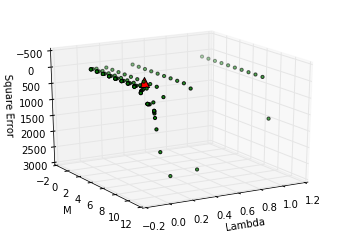

In [6]:
from mpl_toolkits.mplot3d import Axes3D
def plot_cross_validation_error():
    points = [(lamb, M, np.average([error for error, _ in cross_validate(M, lamb)]))
              for M in range(11)
              for lamb in [math.exp(-i) for i in range(11)]]
    lambs, Ms, errors = zip(*points)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(lambs, Ms, errors, c='g', marker='o', s=10)
    ax.scatter([lamb_opt], [M_opt], [min_avg_error], c='r', marker='^', s=100)
    ax.set_xlabel('Lambda')
    ax.set_ylabel('M')
    ax.set_zlabel('Square Error')
    ax.view_init(elev=200)

    plt.show()

plot_cross_validation_error()

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


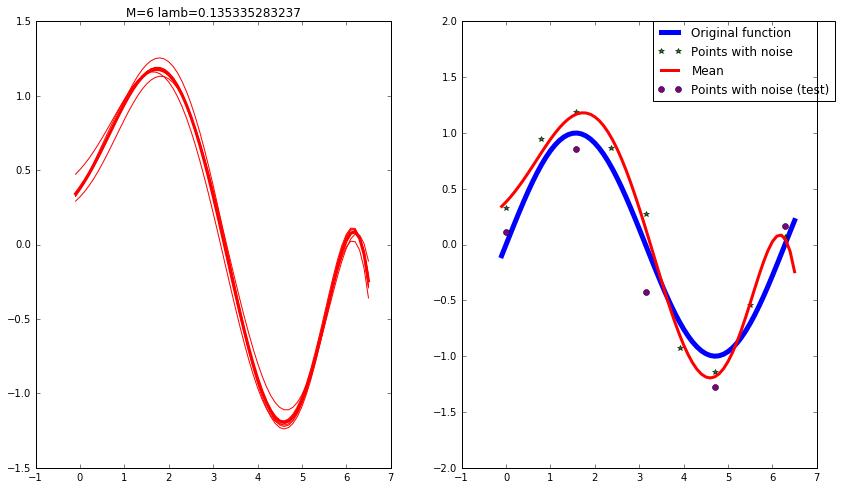

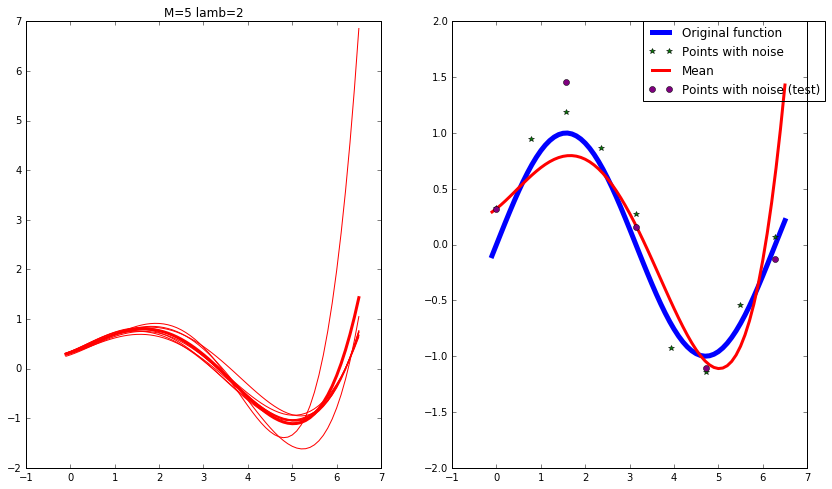

In [7]:
def plot_cross_validation(M, lamb):
    fig = plt.figure()
    fig.set_size_inches(14, 8)

    ax = plt.subplot(121)
    ax.set_title('M=' + str(M) + ' lamb=' + str(lamb))
    mean = np.sum(np.array([t_fit for _, t_fit in cross_validate(M, lamb)]), axis=0) / 9
    for i, (_, t_fit) in enumerate(cross_validate(M, lamb)):
        plt.plot(X, t_fit, label="approximation " + str(i),color='red')
    plt.plot(X, mean, linewidth=3, label="Mean", color='r')

    ax = plt.subplot(122)
    plot_orig()
    plt.plot(X, mean, linewidth=3, label="Mean", color='r')
    
    x_test,t_test = gen_sinusoidal(5) # points we have never seen during our trainings in CV
    plt.plot(x_test, t_test, 'o',color='purple', label='Points with noise (test)')  

    plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
    plt.ylim((-2,2))
    plt.show()

plot_cross_validation(M_opt, lamb_opt)
plot_cross_validation(5, 2) # high bias

Create a comprehensible plot of the cross-validation error for each choice of $M$ and $\lambda$. Highlight the best choice. 

_Question_: Explain over-fitting and underfitting, illuminated by your plot. Explain the relationship with model bias and model variance.

The terms overfitting relate to the problem of a poor generalisation of models on unseen instances (a test set or validation set) while indicating a good fit to training instances (a training set). Formally, overfitting occurs when a model describes random error noise instead of the underlying relationship. The under fitting problems relate to a poor fit to the training set and as a consequence to the test or validation set too. This occurs when the model is incapable of capturing the variability of the data.

In our optimal model we can see that model overfits instances that it has observed during the training time (indicated by star), and does slight worse fitting to test instances ( indicated by circles). Therefore, we can conclude that our model slightly overfits. The second plot (the bottom one) indicate that the model does not fit neither training  nor test instances, and therefore we can say it under fits. Notice that the later has a high regularisation term. 


(The author assumes that the second part of the question is about general models and not the model we obtained by model selection.)

Bishop gives a mathematical definition for high variance and high bias in eq. 3.42 and 3.43 where in order to conclude that the model has low bias it should fit as close as possible the true function $h(x)$ over D datasets without taking into account the noisy instances. So we can say that under fitting relates to the high bias problem. Then variance according to Bishop is how much predictions vary over D datasets and therefore we can relate it to the overfitting problem. 

P.S On the other hand we can’t ignore the fact that from the equations we can have both high bias, and high variance, and MISS all noisy instances in both training and test sets, as the equation does not consider them at all but instead concentrate on the true function and the variance over mean for predictions. The proof requires several plots that the author will provide to provide the point if requested. 


### 1.6 Plot best cross-validated fit (5 points)

For some dataset with $N = 9$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. Let the plot make clear which $M$ and $\lambda$ were found.

M_opt: 6
lamb_opt: 0.135335283237
New dataset: [ 0.          0.78539816  1.57079633  2.35619449  3.14159265  3.92699082
  4.71238898  5.49778714  6.28318531] [ 0.01605782  1.01024041  1.07138771  0.72927181  0.08800882 -0.63842355
 -0.95160873 -0.66863653 -0.2245527 ]


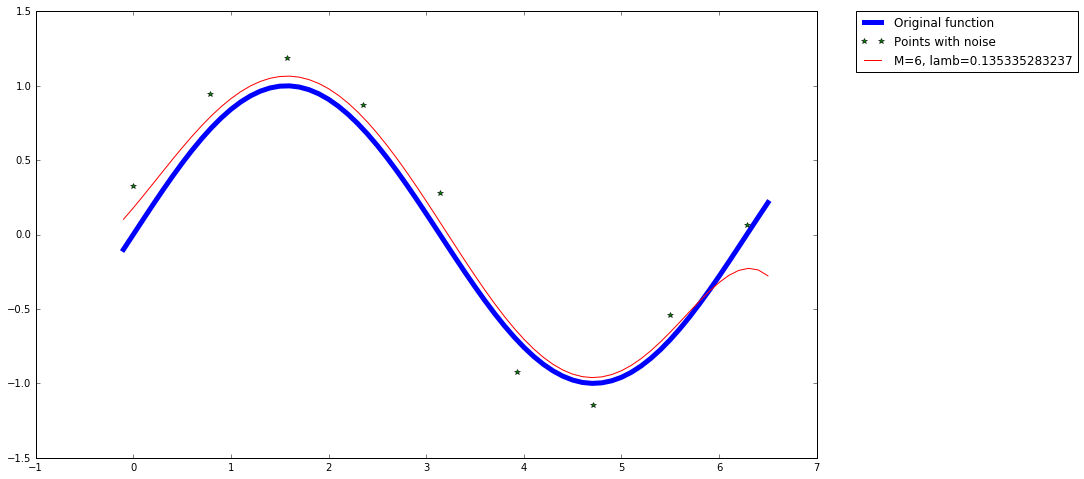

In [8]:
fig = plt.figure()
fig.set_size_inches(14, 8)

print 'M_opt:', M_opt
print 'lamb_opt:', lamb_opt
plot_orig()
X_gen, t_gen = map(np.array, gen_sinusoidal(N))
print 'New dataset:', X_gen, t_gen
plot_approximation(M_opt, lamb_opt, X_gen, t_gen)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sinusoidal data 2 (5 points)

Write a function `gen_sinusoidal2(N)` that behaves identically to `gen_sinusoidal(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [10]:
import numpy as np
import math
import numpy as np
import matplotlib.mlab as mlab
import math
import matplotlib.pyplot as plt
import random

# support functions that will be used later on
def gen_sinusoidal(N):
    N = np.linspace(0, 2 * math.pi, N)
    t_arr = []
    for n in N:
        t = np.random.normal(math.sin(n), 0.2)
        t_arr.append(t)
    return N, t_arr

def get_F(x, M):
    x= x if hasattr(x, "__len__") else [x]

    X = np.ones(len(x))
    # last M is excluded in the range
    for j in range(1, M+1):
        X = np.c_[X, np.power(x, j)]
    return np.array(X)

# returns real prediction value for t
def y(f,w):
    return f.dot(w.transpose())

def gen_sinusoidal2(N):

    x=[]
    for i in range(0,N):
        x.append(random.uniform(0, 2 * math.pi))
    x=sorted(x)
    t_arr = []
    for n in x:
        t = np.random.normal(math.sin(n), 0.2)
        t_arr.append(t)
    return x, t_arr

### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the sinusoidal data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial, given a dataset, where `x`, `t` and `M` have the same meaning as in question 1.2.

In [11]:
def fit_polynomial_bayes(x, t, M, alpha, beta):

    # get F
    F= get_F(x,M)
    I=np.diag(np.ones(np.shape(F)[1]))

    # compute S_n
    S_n=np.linalg.inv(alpha*I +beta*F.transpose().dot(F))

    # compute m_n
    m_n=beta*S_n.dot(F.transpose()).dot(t)

    return m_n, S_n

### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean and variance given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [13]:
def fit_polynomial_bayes(x, t, M, alpha, beta):

    F= get_F(x,M)
    I=np.diag(np.ones(np.shape(F)[1]))

    # compute S_n
    S_n=np.linalg.inv(alpha*I +beta*F.transpose().dot(F))

    # compute m_n
    m_n=beta*S_n.dot(F.transpose()).dot(t)

    return m_n, S_n

In [14]:
# x HAS TO BE SCALAR!
def predict_polynomial_bayes(x, m, S, beta,M=5):
    f= get_F(x,M)
    pred_m = f.dot(m)
    pred_var = 1/beta + f.dot(S).dot(f.transpose())
    return pred_m[0], pred_var[0]

### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 7 datapoints with `gen_sinusoidal2(7)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=5$, $\alpha=\frac{1}{2}$ and $\beta=\frac{1}{0.2^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and a 1-sigma predictive variance using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.

b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 5-th order polynomial regression. 
Display each of these 100 polynomials.

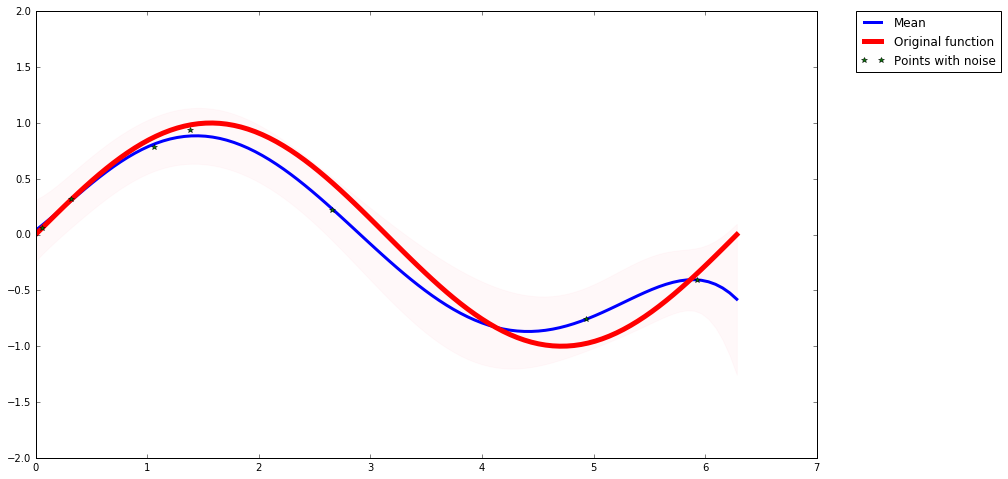

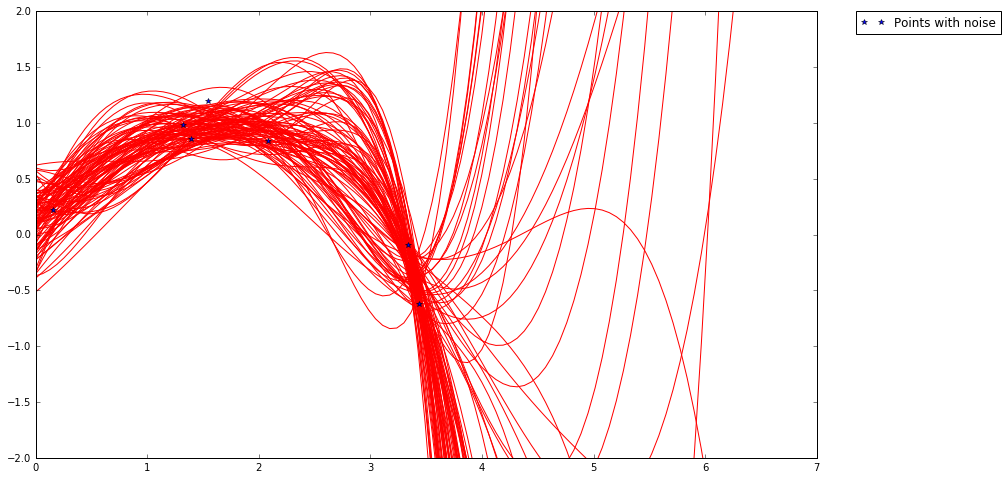

In [15]:
def plot_a():
  fig = plt.figure()
  fig.set_size_inches(14, 8)
  X_cont,t_cont = gen_sinusoidal(100) # to plot smooth curves
  X,t = gen_sinusoidal2(7) # actual points 
  alpha= 0.5
  beta = 1/0.04
  real_t= map(math.sin,X_cont)
  M=5
  m_n,S_n = fit_polynomial_bayes(X,t,M,alpha,beta)
  sigmas = []
  means=[]

  # for each point get mean and variance
  # we iterate over all points to make our curves smooth  
  for x in X_cont:
    res = predict_polynomial_bayes(x,m_n,S_n,beta,M)
    means.append(res[0])
    sigmas.append(math.sqrt(res[1]))

  sigmas=np.array(sigmas)
  means= np.array(means)

  # plotting
  plt.plot(X_cont,means,linewidth=3,label='Mean')
  plt.plot(X_cont,real_t,'k',label='Original function',linewidth=5,color='r')
  plt.plot(X,t,'*',label='Points with noise')
  # we assumed that 1-sigma predictive variance is a type and the author had in mind +- sigma
  # i.e. predictions in one standrd deviation
  plt.fill_between(X_cont,means+sigmas,means-sigmas,color='pink',alpha=0.1)
  plt.ylim((-2,2))
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

  plt.show()

plot_a()



def plot_b():
  fig = plt.figure()
  fig.set_size_inches(14, 8)  
  X_cont,t_cont = gen_sinusoidal(100) # to plot smooth curves
  X,t = gen_sinusoidal2(7)
  alpha= 0.5
  beta = 1/0.04
  M=5
  m_n,S_n = fit_polynomial_bayes(X,t,M,alpha,beta)
  f = get_F(X_cont,M)

  samples=np.random.multivariate_normal( m_n, S_n,100) # since the sampling method was undefined, we have chosen the gaussian
  for samp in samples:
    ys=y(f,samp)
    plt.plot(X_cont,ys,color='red')

  plt.plot(X,t,'*',label='Points with noise')
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.ylim((-2,2))
  plt.show()


plot_b()

### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=\frac{1}{0.2^2}$ the best choice of $\beta$ in section 2.4?

b) (5 points) In the case of Bayesian linear regression, both the posterior of the parameters $p(\bw \;|\; \bt, \alpha, \beta)$ and the predictive distribution $p(t \;|\; \bw, \beta)$ are Gaussian. In consequence (and conveniently), $p(t \;|\; \bt, \alpha, \beta)$ is also Gaussian (See MLPR section 3.3.2 and homework 2 question 4). This is actually one of the (rare) cases where we can make Bayesian predictions without resorting to approximative methods.

Suppose you have to work with some model $p(t\;|\;x,\bw)$ with parameters $\bw$, where the posterior distribution $p(\bw\;|\;\mathcal{D})$ given dataset $\mathcal{D}$ can not be integrated out when making predictions, but where you can still generate samples from the posterior distribution of the parameters. Explain how you can still make approximate Bayesian predictions using samples from the parameters' posterior distribution.

a) Because we have generated our data with a standard deviation for noise $\sigma = 0.2$, therefore $\beta=\frac{1}{\sigma^2}=\frac{1}{0.2^2}$, that's a noise precision will be the best choice of $\beta$ in section 2.4.

b) In order to avoid the integration and we could use a number of approximation techniques from numerical integration, such as Riemann sum or Trapezoid rule, where we set the number of samples we are interested in and omit setting : $ \lim_{n\rightarrow \infty}$.  On the other hand, the numerical integral is usually applied to definite integrals and thus we will need to set the upper and lower limits for the integral. Alternative technique is the Taylor series expansion of exponent functions, which is: 
$\exp(x)= \sum_{k=1}^{+\infty} \frac{x^k}{k!} = 1+ x+\frac{x^2}{2!}+…$. So we can approximate by converting the exponent into a polynomial and then integrating, and the more terms we use the better is the approximation. 
 